# DATA EXPLORATION

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB
None


First Few Rows:
   Transaction_ID       Timestamp 

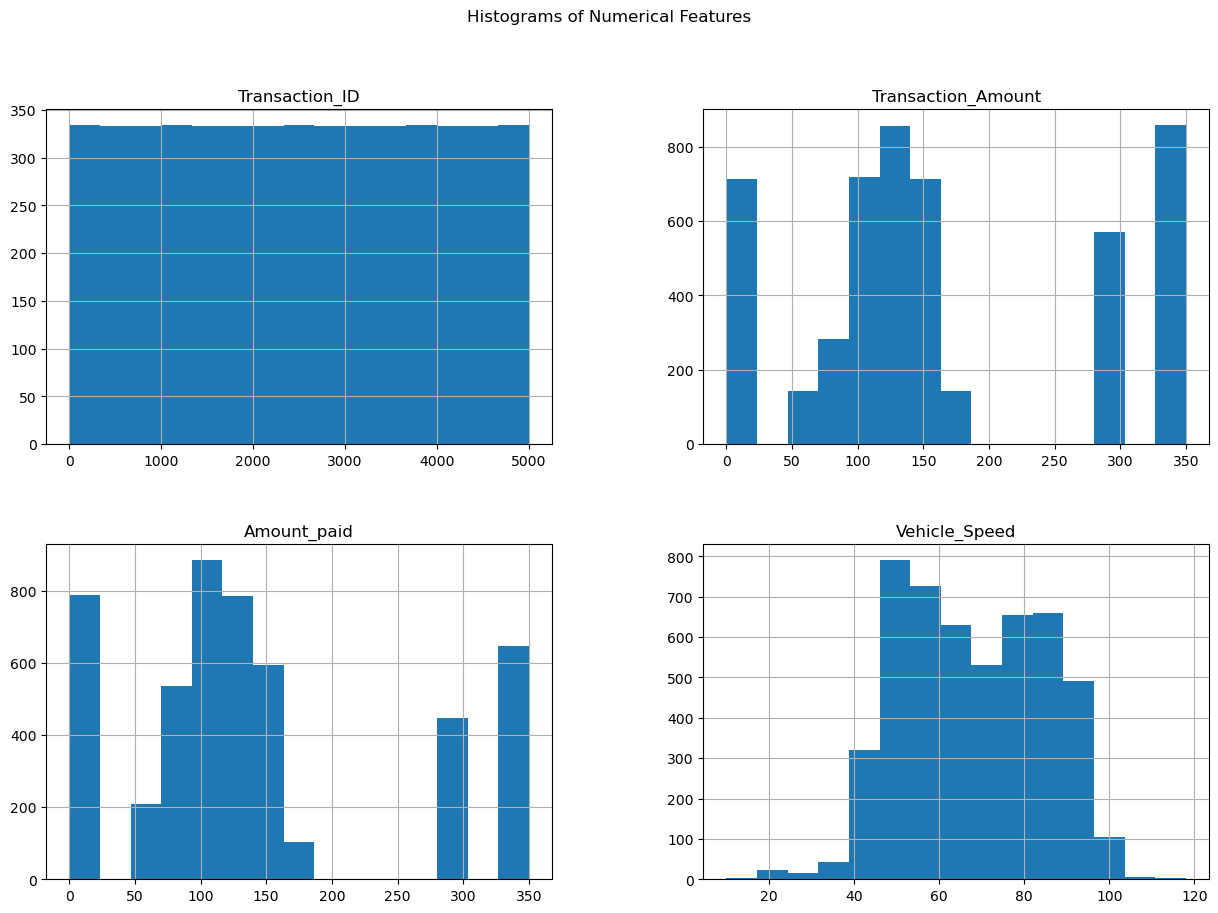

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'FastagFraudDetection.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Basic Information:")
print(df.info())
print("\n")

# Display the first few rows of the dataset
print("First Few Rows:")
print(df.head())
print("\n")

# Display summary statistics
print("Summary Statistics:")
print(df.describe(include='all'))
print("\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n")

# Visualize the distribution of key variables
# Histograms for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

df[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Count plots for categorical features
categorical_features = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# FEATURE ENGINEERING

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'FastagFraudDetection.csv'
df = pd.read_csv(file_path)

# Feature Engineering

# 1. Extract information from Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year

# 2. Convert categorical features into numerical representations
# Vehicle_Type
df = pd.get_dummies(df, columns=['Vehicle_Type'], drop_first=True)

# Lane_Type
df = pd.get_dummies(df, columns=['Lane_Type'], drop_first=True)

# Vehicle_Dimensions
df = pd.get_dummies(df, columns=['Vehicle_Dimensions'], drop_first=True)

# Geographical_Location
df = pd.get_dummies(df, columns=['Geographical_Location'], drop_first=True)

# Fraud_indicator (target variable encoding)
df['Fraud_indicator'] = df['Fraud_indicator'].apply(lambda x: 1 if x == 'Fraud' else 0)

# 3. Create new features
df['Amount_Difference'] = df['Transaction_Amount'] - df['Amount_paid']

# 4. Categorize Vehicle_Speed into bins
speed_bins = [0, 30, 60, 120]
speed_labels = ['slow', 'medium', 'fast']
df['Speed_Category'] = pd.cut(df['Vehicle_Speed'], bins=speed_bins, labels=speed_labels)

# Convert Speed_Category to numerical
df = pd.get_dummies(df, columns=['Speed_Category'], drop_first=True)

# Drop the original 'Timestamp' column as we have extracted relevant features
df.drop(columns=['Timestamp'], inplace=True)

# Drop 'FastagID' and 'Vehicle_Plate_Number' since they may not contribute to the model directly
df.drop(columns=['FastagID', 'Vehicle_Plate_Number'], inplace=True)

# Display the first few rows of the engineered dataset
print(df.head())

# Save the engineered dataset
df.to_csv('FastagFraudDetection_engineered.csv', index=False)


# MODEL DEVELOPMENT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the engineered dataset
file_path = 'FastagFraudDetection_engineered.csv'
df = pd.read_csv(file_path)

# Separate features and target variable
X = df.drop(columns=['Fraud_indicator'])
y = df['Fraud_indicator']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)

# Save the model
model_file_path = 'logistic_regression_model.pkl'
joblib.dump(model, model_file_path)


# REAL-TIME FRAUD DETECTION

In [ ]:
import pandas as pd
import joblib
from flask import Flask, request, jsonify

# Load the trained model
model_file_path = 'logistic_regression_model.pkl'
model = joblib.load(model_file_path)

# Create a Flask application
app = Flask(__name__)

# Define the preprocessing function
def preprocess_data(data):
    # Convert data to DataFrame
    df = pd.DataFrame(data, index=[0])

    # Extract features from Timestamp
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Hour'] = df['Timestamp'].dt.hour
    df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
    df['Month'] = df['Timestamp'].dt.month
    df['Year'] = df['Timestamp'].dt.year

    # Drop the original 'Timestamp' column
    df.drop(columns=['Timestamp'], inplace=True)

    # Convert categorical features into numerical representations
    # (Assuming these were the features in the training dataset)
    categorical_columns = ['Vehicle_Type', 'Lane_Type', 'Vehicle_Dimensions', 'Geographical_Location', 'Speed_Category']
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Create new features
    df['Amount_Difference'] = df['Transaction_Amount'] - df['Amount_paid']

    return df

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    # Get the data from the POST request
    data = request.get_json(force=True)

    # Preprocess the data
    preprocessed_data = preprocess_data(data)

    # Ensure the order of columns matches the training data
    model_features = model.feature_names_in_
    preprocessed_data = preprocessed_data.reindex(columns=model_features, fill_value=0)

    # Make prediction
    prediction = model.predict(preprocessed_data)

    # Return the prediction result
    result = {'Fraud_indicator': int(prediction[0])}
    return jsonify(result)

if __name__ == '__main__':
    app.run(debug=True)


# EXPLANATORY ANALYSIS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'FastagFraudDetection.csv'
df = pd.read_csv(file_path)

# Basic Information
print("Basic Information:")
print(df.info())
print("\n")

print("First Few Rows:")
print(df.head())
print("\n")

print("Summary Statistics:")
print(df.describe(include='all'))
print("\n")

print("Missing Values:")
print(df.isnull().sum())
print("\n")

# Univariate Analysis

# Histograms for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    df[column].hist(bins=15)
    plt.title(column)
plt.tight_layout()
plt.show()

# Count plots for categorical features
categorical_features = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

# Bivariate Analysis

# Box plots for numerical features vs. Fraud_indicator
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Fraud_indicator', y=column, data=df)
    plt.title(f'{column} vs. Fraud_indicator')
plt.tight_layout()
plt.show()

# Count plots for categorical features vs. Fraud_indicator
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x='Fraud_indicator', hue=column, data=df)
    plt.title(f'{column} vs. Fraud_indicator')
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for numerical features
sns.pairplot(df, hue='Fraud_indicator', diag_kind='kde')
plt.show()